In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.rcParams['figure.dpi'] = 200
plt.style.use('ggplot')

* Our goal is to predict a target value $y$ from a vector input variables $\mathbf{x} = [x^1, x^2, \cdots, x^M]$.

* For example, $y$ is the mid-price of AAPL at next time step (1 second per time step) and $\mathbf{x}$ is limit order book data.

* Suppose that we are given many examples $\mathcal{D}_{train} = (\mathbf{x}_n, y_n)_{n=1}^N$, where $n$ represents the $n$-th sample.

* We want to find a function $\hat{y} = f(\mathbf{x})$ so that we have $y \approx \hat{y}$ for any $\mathbf{x}$.

* First, we must decide the form of $f(\mathbf{x})$.

* We start from linear functions: $f_{\theta}(\mathbf{x}) = \sum_{j=1}^M \theta_j x^j = \boldsymbol{\theta}^{\top}\mathbf{x}$.

In [2]:
import torch

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
dtype = torch.float

theta_0 = torch.ones((), device=device, dtype=dtype, requires_grad=True) 
theta_1 = torch.zeros((), device=device, dtype=dtype, requires_grad=True)
theta_2 = torch.zeros((), device=device, dtype=dtype, requires_grad=True)

def linear_model(
    x: torch.Tensor
):
    return theta_1 * x[:, 0] + theta_2 * x[:, 1] + theta_0

* With this linear form of $f(\cdot)$, our task is to find $\boldsymbol{\theta}$ so that $f_{\theta}(\mathbf{x}_n)$ is as close as possible to $y_n$.

* We translate our goal to an object function (a.k.a. loss function). We will search for $\boldsymbol{\theta}$ that optimize that object function:

$$\mathcal{L}(\boldsymbol{\theta}) = \frac{1}{2}\sum_{n=1}^N(f_{\theta}(\mathbf{x}_n) - y_n)^2 = \frac{1}{2} \sum_{n=1}^N(\boldsymbol{\theta}^{\top} \mathbf{x}_n - y_n)^2$$

In [18]:
def mean_squared_error(
    y_pred: torch.Tensor, 
    y: torch.Tensor,
    ):
    return (y_pred - y).pow(2).sum()

* There are many algorithms for optimizing the object function.

* Linear models with mean squared error object function can be solved analytically.

* However, analytical solutions do no exist in most cases.

* We introduce an easy and general method to minimize any differentiable loss function.

* Gradient descent is an optimization algorithm to minimize some function by iteratively moving in the direction of steepest descent as defined by the negative gradient.

* The gradient with respect to model parameters $\boldsymbol{\theta}$

$$
\nabla_{\boldsymbol{\theta}} \mathcal{L}(\boldsymbol{\theta}) = \left[\begin{array}{c}
\frac{\partial  \mathcal{L}(\boldsymbol{\theta})}{\partial \theta_1}\\
\frac{\partial  \mathcal{L}(\boldsymbol{\theta})}{\partial \theta_i}\\
\vdots\\
\frac{\partial  \mathcal{L}(\boldsymbol{\theta})}{\partial \theta_M}
\end{array}
\right]
$$

* Specifically, 

$$\frac{\partial  \mathcal{L}(\boldsymbol{\theta})}{\partial \theta_j} = \sum_{n=1}^N x_n^j (\boldsymbol{\theta}^{\top} \mathbf{x} - y_n)$$

* In the $t$-the iteration, we update the model parameters $\boldsymbol{\theta}$ in the following form

$$\boldsymbol{\theta}^{t+1} = \boldsymbol{\theta} ^t - \alpha \nabla_{\boldsymbol{\theta}} \mathcal{L}(\boldsymbol{\theta}^t)$$

In [7]:
# generate some toy data
# y = 0.4 * x_1 - 0.7 * x_2 + noise

x = np.random.randn(2000, 2)
y = 0.4 * x[:, 0] - 0.7 * x[:, 1] + np.random.randn(2000) * 0.1

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
dtype = torch.float

x_train = torch.tensor(x[:1000], device=device, dtype=dtype)
y_train = torch.tensor(y[:1000], device=device, dtype=dtype)

x_test = torch.tensor(x[1000:], device=device, dtype=dtype)
y_test = torch.tensor(y[1000:], device=device, dtype=dtype)

The standard procedure to train a model using $\mathcal{D}_{train} = (\mathbf{x}_n, y_n)_{n=1}^N$

1. Forward pass to get the predicted output $\hat{y}_n = f_{\theta}(\mathbf{x}_n)$
2. Backward pass to get the gradient $\nabla_{\boldsymbol{\theta}} \mathcal{L}(\boldsymbol{\theta})$
3. Update the parameters using the gradient $\boldsymbol{\theta}^{t+1} = \boldsymbol{\theta} ^t - \alpha \nabla_{\boldsymbol{\theta}} \mathcal{L}(\boldsymbol{\theta})$
4. Go back to Step 1

The most challenging step is the backward pass due to the computation of gradient. Fortunately, modern deep learning libraries like PyTorch and TensorFlow offer **automatic differentiation** function. Users do not have to worry about how to compute the gradient in most of the time. 

In the following example, we do everything manually except the backward pass step. 


In [20]:
learning_rate = 1e-4

loss_list = []
theta_0_list = []
theta_1_list = []
theta_2_list = []
theta_0_list.append(theta_0.item())
theta_1_list.append(theta_1.item())
theta_2_list.append(theta_2.item())


for t in range(200):
    # forward pass
    # y_hat = f(x)
    y_pred = linear_model(x_train)

    # compute the loss 
    loss = (y_pred - y_train).pow(2).sum()

    # backward pass
    # it automatically computes the gradient with respect to the parameters
    loss.backward()

    with torch.no_grad():
        # update model parameters along the direction of negative gradient
        theta_0 -= learning_rate * theta_0.grad
        theta_1 -= learning_rate * theta_1.grad
        theta_2 -= learning_rate * theta_2.grad

        # manually zero out the gradients
        theta_0.grad = None
        theta_1.grad = None
        theta_2.grad = None

    loss_list.append(loss.item())
    theta_0_list.append(theta_0.item())
    theta_1_list.append(theta_1.item())
    theta_2_list.append(theta_2.item())

print('theta_0: ', theta_0.item())
print('theta_1 :', theta_1.item())
print('theta_2 :', theta_2.item())


theta_0:  0.0035965105053037405
theta_1 : 0.3982519507408142
theta_2 : -0.6966767907142639


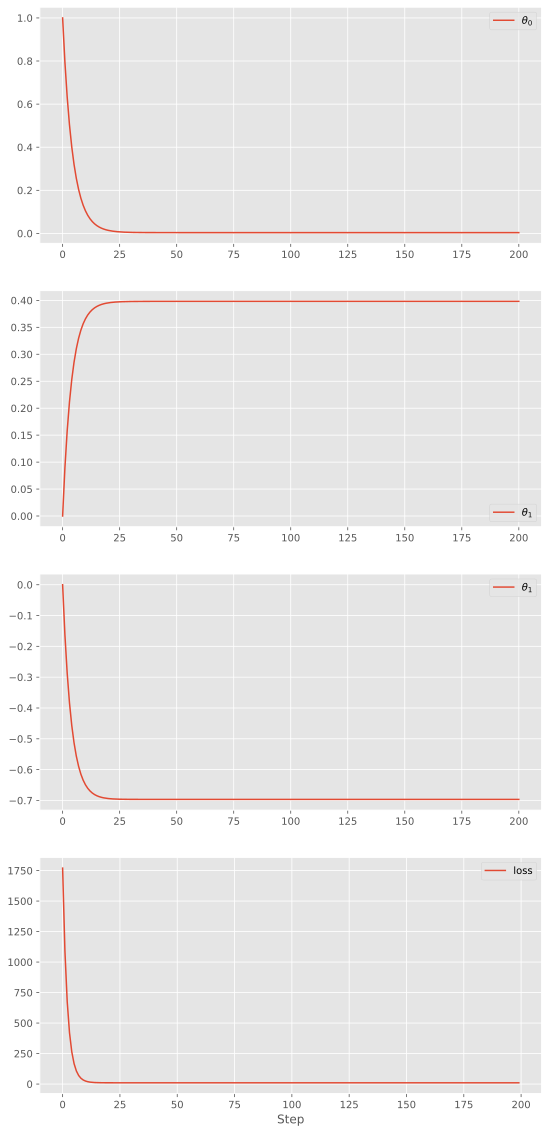

In [21]:
fig, axes = plt.subplots(4, 1, figsize=(9, 20))
axes[0].plot(theta_0_list, label=r'$\theta_0$')
axes[0].legend()
axes[1].plot(theta_1_list, label=r'$\theta_1$')
axes[1].legend()
axes[2].plot(theta_2_list, label=r'$\theta_1$')
axes[2].legend()
axes[3].plot(loss_list, label='loss')
axes[3].legend()
axes[3].set_xlabel('Step')
plt.show()

* In the previous example, we define the model manually and update the parameters manually

* It becomes very inconvenient if you have a model with one billion parameters 

* We show the canonical way of learning a model  

In [19]:
from torch import nn

# define our model by inheriting a predefined class
class LinearModel(nn.Module):
    def __init__(
        self, 
        input_dim: int, 
        output_dim: int, 
        ):
        super().__init__()
        self.linear = nn.Linear(in_features=input_dim, out_features=output_dim, bias=True)

    def forward(self, x):
        # this is y_hat = f(x)
        y_hat = self.linear(x)
        return y_hat

linear_model_pytorch = LinearModel(input_dim=2, output_dim=1)

In [20]:
from torch.optim import SGD

# Use the build-in Stochastic Gradient Descent (SGD) optimizer
optimizer = SGD(
    params=linear_model_pytorch.parameters(),   # the parameter you want to optimize
    lr=1e-4,                                    # learning rate
    )

In [21]:
# use mean squared error os the loss function
criterion = nn.MSELoss(reduction='sum')

In [22]:
# switch to training mode
linear_model_pytorch.train()

# define the training loop

for epoch in range(200):

     # forward pass
     pred_y = linear_model_pytorch(x_train)

     # compute the loss
     loss = criterion(pred_y.reshape(-1), y_train)

     # backward pass to compute the gradient
     loss.backward()

     # update the model parameters using the gradient
     optimizer.step()

     # zero the parameter gradients
     optimizer.zero_grad()



In [18]:
print(linear_model_pytorch.linear.weight.data)
print(linear_model_pytorch.linear.bias.data)

tensor([[ 0.3894, -0.7012]])
tensor([-0.0054])


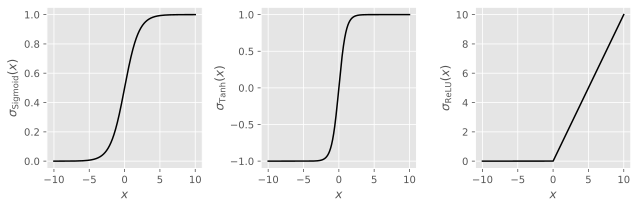

In [24]:
tanh_func = nn.Tanh()
relu_func = nn.ReLU()
sigmoid_func = nn.Sigmoid()
x = torch.linspace(-10, 10, 2000)
y_relu = relu_func(x).numpy()
y_tanh = tanh_func(x).numpy()
y_sigmoid = sigmoid_func(x).numpy()
x = x.numpy()



fig, axes = plt.subplots(1, 3, figsize=(9, 3))
axes[0].plot(x, y_sigmoid, color='black')
# axes[0].grid()
axes[0].set_xlabel(r'$x$')
axes[0].set_ylabel(r'$\sigma_{\mathrm{Sigmoid}}(x)$')
axes[1].plot(x, y_tanh, color='black')
# axes[1].grid()
axes[1].set_xlabel(r'$x$')
axes[1].set_ylabel(r'$\sigma_{\mathrm{Tanh}}(x)$')
axes[2].plot(x, y_relu, color='black')
# axes[2].grid()
axes[2].set_xlabel(r'$x$')
axes[2].set_ylabel(r'$\sigma_{\mathrm{ReLU}}(x)$')
plt.tight_layout()
plt.show()

In [ ]:
import torch.nn.functional as F
from torch.distributions import Bernoulli


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


class DropBlock(nn.Module):
    def __init__(self, block_size):
        super(DropBlock, self).__init__()

        self.block_size = block_size
        # self.gamma = gamma
        # self.bernouli = Bernoulli(gamma)

    def forward(self, x, gamma):
        # shape: (bsize, channels, height, width)

        if self.training:
            batch_size, channels, height, width = x.shape

            bernoulli = Bernoulli(gamma)
            mask = bernoulli.sample(
                (batch_size, channels, height - (self.block_size - 1), width - (self.block_size - 1))).cuda()
            block_mask = self._compute_block_mask(mask)
            countM = block_mask.size()[0] * block_mask.size()[1] * block_mask.size()[2] * block_mask.size()[3]
            count_ones = block_mask.sum()

            return block_mask * x * (countM / count_ones)
        else:
            return x

    def _compute_block_mask(self, mask):
        left_padding = int((self.block_size - 1) / 2)
        right_padding = int(self.block_size / 2)

        batch_size, channels, height, width = mask.shape
        # print ("mask", mask[0][0])
        # non_zero_idxs = mask.nonzero()
        non_zero_idxs = torch.nonzero(mask, as_tuple=False)
        nr_blocks = non_zero_idxs.shape[0]

        offsets = torch.stack(
            [
                torch.arange(self.block_size).view(-1, 1).expand(self.block_size, self.block_size).reshape(-1),
                # - left_padding,
                torch.arange(self.block_size).repeat(self.block_size),  # - left_padding
            ]
        ).t().cuda()
        offsets = torch.cat((torch.zeros(self.block_size ** 2, 2).cuda().long(), offsets.long()), 1)

        if nr_blocks > 0:
            non_zero_idxs = non_zero_idxs.repeat(self.block_size ** 2, 1)
            offsets = offsets.repeat(nr_blocks, 1).view(-1, 4)
            offsets = offsets.long()

            block_idxs = non_zero_idxs + offsets
            # block_idxs += left_padding
            padded_mask = F.pad(mask, [left_padding, right_padding, left_padding, right_padding])
            padded_mask[block_idxs[:, 0], block_idxs[:, 1], block_idxs[:, 2], block_idxs[:, 3]] = 1.
        else:
            padded_mask = F.pad(mask, [left_padding, right_padding, left_padding, right_padding])

        block_mask = 1 - padded_mask  # [:height, :width]
        return block_mask


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, drop_rate=0.0, drop_block=False,
                 block_size=1, use_se=False):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.LeakyReLU(0.1)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv3x3(planes, planes)
        self.bn3 = nn.BatchNorm2d(planes)
        self.maxpool = nn.MaxPool2d(stride)
        self.downsample = downsample
        self.stride = stride
        self.drop_rate = drop_rate
        self.num_batches_tracked = 0
        self.drop_block = drop_block
        self.block_size = block_size
        self.DropBlock = DropBlock(block_size=self.block_size)
        self.use_se = use_se
        if self.use_se:
            self.se = SELayer(planes, 4)

    def forward(self, x):
        self.num_batches_tracked += 1

        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        if self.use_se:
            out = self.se(out)

        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        out = self.maxpool(out)

        if self.drop_rate > 0:
            if self.drop_block:
                feat_size = out.size()[2]
                keep_rate = max(1.0 - self.drop_rate / (20 * 2000) * self.num_batches_tracked, 1.0 - self.drop_rate)
                gamma = (1 - keep_rate) / self.block_size ** 2 * feat_size ** 2 / (feat_size - self.block_size + 1) ** 2
                out = self.DropBlock(out, gamma=gamma)
            else:
                out = F.dropout(out, p=self.drop_rate, training=self.training, inplace=True)

        return out


class ResNet(nn.Module):

    def __init__(self, block, n_blocks, keep_prob=1.0, avg_pool=False, drop_rate=0.0,
                 dropblock_size=5, num_classes=-1, use_se=False, in_channel=3):
        super(ResNet, self).__init__()

        self.inplanes = in_channel
        self.use_se = use_se
        self.layer1 = self._make_layer(block, n_blocks[0], 64,
                                       stride=2, drop_rate=drop_rate)
        self.layer2 = self._make_layer(block, n_blocks[1], 160,
                                       stride=2, drop_rate=drop_rate)
        self.layer3 = self._make_layer(block, n_blocks[2], 320,
                                       stride=2, drop_rate=drop_rate, drop_block=True, block_size=dropblock_size)
        self.layer4 = self._make_layer(block, n_blocks[3], 640,
                                       stride=2, drop_rate=drop_rate, drop_block=True, block_size=dropblock_size)
        if avg_pool:
            # self.avgpool = nn.AvgPool2d(5, stride=1)
            self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.keep_prob = keep_prob
        self.keep_avg_pool = avg_pool
        self.dropout = nn.Dropout(p=1 - self.keep_prob, inplace=False)
        self.drop_rate = drop_rate

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        self.num_classes = num_classes
        self.fc = nn.Linear(640, self.num_classes)

    def _make_layer(self, block, n_block, planes, stride=1, drop_rate=0.0, drop_block=False, block_size=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        if n_block == 1:
            layer = block(self.inplanes, planes, stride, downsample, drop_rate, drop_block, block_size, self.use_se)
        else:
            layer = block(self.inplanes, planes, stride, downsample, drop_rate, self.use_se)
        layers.append(layer)
        self.inplanes = planes * block.expansion

        for i in range(1, n_block):
            if i == n_block - 1:
                layer = block(self.inplanes, planes, drop_rate=drop_rate, drop_block=drop_block,
                              block_size=block_size, use_se=self.use_se)
            else:
                layer = block(self.inplanes, planes, drop_rate=drop_rate, use_se=self.use_se)
            layers.append(layer)

        return nn.Sequential(*layers)

    def forward(self, x, pool=True):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        if pool:
            x = self.avgpool(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)

        return x

    def get_feature(self, x, pool=True):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        if pool:
            x = self.avgpool(x)
        x = x.reshape(x.size(0), -1)
        return x


def resnet12(keep_prob=1.0, avg_pool=True, drop_rate=0.1, dropblock_size=2, **kwargs):
    """Constructs a ResNet-12 model.
    """
    model = ResNet(BasicBlock, [1, 1, 1, 1], keep_prob=keep_prob, avg_pool=avg_pool,
                   drop_rate=drop_rate, dropblock_size=dropblock_size, **kwargs)
    return model

![alt text](images/resnet_12.jpg "Title")

In [ ]:
# load limit order book data
dec_data = np.loadtxt('data/Train_Dst_NoAuction_DecPre_CF_7.txt')
dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]

dec_test1 = np.loadtxt('data/Test_Dst_NoAuction_DecPre_CF_7.txt')
dec_test2 = np.loadtxt('data/Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test3 = np.loadtxt('data/Test_Dst_NoAuction_DecPre_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))



dataset_train = LobDataset(data=dec_train, k=4, num_classes=3, T=100)
dataset_val = LobDataset(data=dec_val, k=4, num_classes=3, T=100)
dataset_test = LobDataset(data=dec_test, k=4, num_classes=3, T=100)


batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

In [ ]:
# initialize the model
model = resnet12(avg_pool=True, drop_rate=0.1, dropblock_size=2, in_channel=1, num_classes=dataset_train.num_classes)

# send the model to CPU or GPU
model.to(device)

# define the object function
criterion = nn.CrossEntropyLoss()

# define the stochastic gradient descent optimizer
optimizer = SGD(
    model.parameters(),     # parameters that you want to optimize
    lr=0.0001,              # learning rate
    )

In [ ]:
from tqdm import tqdm
from datetime import datetime

def train_model(model, criterion, optimizer, train_loader, val_loader, epochs):
    train_losses = np.zeros(epochs)
    val_losses = np.zeros(epochs)
    best_val_loss = np.inf
    best_val_epoch = 0

    for it in tqdm(range(epochs)):

        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

            # Forward pass
            outputs = model(inputs)

            # compute the loss
            loss = criterion(outputs, targets)

            # Backward pass
            loss.backward()

            # update the model parameters using the gradient
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            train_loss.append(loss.item())

        # Get train loss and test loss
        train_loss = np.mean(train_loss)  # a little misleading

        model.eval()
        val_loss = []
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss.append(loss.item())
        val_loss = np.mean(val_loss)

        # Save losses
        train_losses[it] = train_loss
        val_losses[it] = val_loss

        if val_loss < best_val_loss:
            torch.save(model, 'saved_models/best_lob_model.pt')
            best_val_loss = val_loss
            best_val_epoch = it
            print('model saved')

        dt = datetime.now() - t0
        print(f'Epoch {it + 1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {val_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_val_epoch}')

    return train_losses, val_losses

In [ ]:
train_model(model, criterion, optimizer, train_loader, val_loader, epochs=200)

|   | Precision  | Recall  | F1  | Acc  |
|---|---|---|---|---|
| ResNet | 76.13% | 76.03% | 76.05%  | 76.06% |
| Linear | 58.22% | 55.29% | 48.56%  | 54.53% |
